In [ ]:
%pip install timm torchinfo split-folders tqdm

## Imports

In [ ]:
import os
import splitfolders
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
from timeit import default_timer as timer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
from timm.optim import Lookahead
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

ModuleNotFoundError: No module named 'splitfolders'

## Helper Functions

In [ ]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of rsults dictionary"""
    # Get the loss values of results dictionary (training and test)
    loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and val)
    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]
    # Figure out number of epochs
    epochs = range(len(results["train_loss"]))
    # Setup a plot
    plt.figure(figsize=(15,7))
    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, val_accuracy, label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

In [ ]:
def evaluate_f1(model, dataloader, device):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())  # Move to CPU and store
            all_labels.extend(labels.cpu().numpy())  # Move to CPU and store

    # Compute F1 score (macro for multi-class)
    f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' for multi-class
    return f1

## Device agnoistic

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## Data Augmentation and Preprocessing

steps:

1. Split the data into train (80%), test (10%), valid (10%) and named the folder Pap-VAL
2. Get to know the number of folders and images in the dataset.
3. Prepare the Image Folders using transformations.
4. Using the Image Folders prepare the dataloaders for the training.

In [ ]:
data_path = Path("./dataset/")
input_folder = data_path / "papcell"
output_folder = data_path / "Pap-VAL"
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

In [ ]:
image_path = data_path / "Pap-VAL"
walk_through_dir(image_path)

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

## Experiment 1
Data preprocessing and Augmenbtation Techniques:
We resize the images into size 256 x 256.Then we Crop image size 224 x 224r for training. we applied various image augmentation techniques " flip, rotation, shear, Normalization". For Noramalization we used ImageNet pretrained model values as they shows a good performance on complex task.


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, shear=15, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 16

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)
val_data = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

------------------------Imbalanceds data classes------------------------------
As the unhealthy class has a very small number of samples compared to the other two classes, we used categorical weighted focal loss. In this first experiment, the alpha parameter is equal for all three classes: 0.25. This helped us understand the effect of changing alpha values in the subsequent experiments and how this affected the model's performance. To improve the robustness and generalization ability of the models in my ensemble, we applied FocalLossWithLabelSmoothing. This technique helped address class imbalance, reduced overfitting, and ensured that the models didn't become too overconfident in their predictions, leading to more reliable and diverse models. The combination of focal loss and label smoothing also encouraged the individual models to focus on difficult examples, which enhanced the overall performance when combined in an ensemble.
We would like top clarify an important point: in the final test phase we used ensemble model to enhance the predictions. The decision of which models to ensemble was based on studying the results of the confusion matrix on the test data "10% of the training data"; It was not arbitray.  

Loss Functions
  Focal Loss was used with a hybrid CNN + ViT.

  Focal Loss + Label Smoothing for Hybrid CNN + Swin Transformer: This function provides the same alpha parameter for all classes.

  Focal Loss with Class Weights was used with Hybrid CNN + Swin Transformer: This function provided flexibility by setting different weights for the classes, giving a higher weight to the "hard" class, which in this challenge was the unhealthy class.

Note: Focal Weighted Loss was used to address the imbalanced data in this challenge.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
class FocalLossWithLabelSmoothing(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smoothing=0.1):
        super(FocalLossWithLabelSmoothing, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / inputs.size(1)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
class FocalLossWithClassWeights(nn.Module):
    def __init__(self, class_alpha=[0.25, 0.25, 0.75], gamma=2.0, smoothing=0.1):
        """
        class_alpha: List containing alpha values for each class
        gamma: Focusing parameter for Focal Loss
        smoothing: Label smoothing factor
        """
        super(FocalLossWithClassWeights, self).__init__()
        self.class_alpha = torch.tensor(class_alpha).to(device)  # Convert to tensor and send to device
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / inputs.size(1)

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        alpha_weights = self.class_alpha[targets.argmax(dim=1)]
        focal_loss = alpha_weights * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

Model 1: Hybrid CNN and ViT

 This is the structure of our model

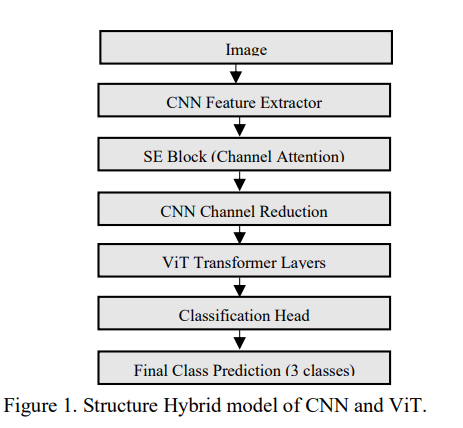


HybridViT (CNN + ViT Transformer)

We have proposed and developed SE Attention Block and combined it with the pretrained ViT transformer for better accuracy.

1. SE Attention Block
* Enhances channel-wise feature importance by re-weighting channels dynamically.
* Uses Global Average Pooling (GAP) to capture global dependencies.
2. GELU Activation Function
* Helps reduce dying neurons issue compared to ReLU.
3. CNN (Convolutional Stem)
* Extracts local spatial features from input images.
* Detects edges, textures, and fine details.
4. ViT Feature Extractor
* Processes global dependencies using self-attention.
* Divides the image into patches and treats them as tokens.
5. CNN + ViT
* CNN captures low-level spatial features (edges, textures).
* ViT captures global dependencies and contextual relationships.

Note: we used Pretrained ViT model with weights and the training process was like fine-tuning the parameters of ViT to our task.




In [ ]:
# SE Attention Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.GELU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        scale = self.global_avg_pool(x).view(batch, channels)
        scale = self.fc(scale).view(batch, channels, 1, 1)
        return x * scale


# Hybrid CNN-ViT Model (Fixed)
class HybridViT(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridViT, self).__init__()

        # Convolutional Stem (Fixed: Reducing channels back to 3)
        self.conv_stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            SEBlock(128),
            nn.Conv2d(128, 3, kernel_size=1, stride=1, padding=0, bias=False),  # Reduce channels to 3
            nn.BatchNorm2d(3),
            nn.GELU()
        )

        # Load Pretrained Vision Transformer (ViT)
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.conv_stem(x)  # CNN Feature Extraction
        x = self.vit(x)  # Vision Transformer
        return x

In [ ]:
model_1 = HybridViT(num_classes=len(train_data.classes)).to(device)
summary(model=model_1,
        input_size=(8, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

AdamW is an improved version of Adam that decouples weight decay from gradient updates, preventing excessive L2 regularization and improving generalization in deep learning models.

Lookahead is maintaining a slow-moving version of model parameters that updates every k=5 steps with an alpha=0.5 interpolation. This helps improve training stability and convergence.

Schedular gradually reduces the learning rate following a cosine curve over T_max=10 epochs, preventing sudden learning rate drops and helping the model settle into better minima.

GradScaler enables Automatic Mixed Precision (AMP) training, scaling gradients to prevent underflow issues in float16 computations, reducing memory usage, and speeding up training on GPUs.

In [ ]:
model_1 = HybridViT(num_classes=len(train_data.classes)).to(device)
base_optimizer = optim.AdamW(model_1.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()
model_1(image_batch.to(device))

Training the Model:

The training process runs for ten epochs, where the model alternates between training and validation phases. In training, it is set to training mode, processes batches of images, computes predictions, and calculates loss using Focal Loss to handle class imbalance. Automatic Mixed Precision (AMP) with gradient scaling ensures efficient and stable updates. The optimizer adjusts model weights after each batch.

In validation, the model switches to evaluation mode, processes images without computing gradients, and computes accuracy and loss for performance tracking. A learning rate scheduler updates the optimizer dynamically to improve convergence.


In [ ]:
model_1_results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# Training Loop
EPOCHS = 10
start_timer = timer()
for epoch in tqdm(range(EPOCHS)):
    model_1.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred = model_1(X)
            loss = FocalLoss()(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    model_1_results["train_loss"].append(train_loss)
    model_1_results["train_acc"].append(train_acc)
    model_1.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_dataloader):
            X, y = X.to(device), y.to(device)
            with autocast():
                val_pred_logits = model_1(X)
                loss = FocalLoss()(val_pred_logits, y)
            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    model_1_results["val_loss"].append(val_loss)
    model_1_results["val_acc"].append(val_acc)
    scheduler.step()
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
# End timer
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")
torch.save(model_1.state_dict(), "model_1.pth")

Evaluation Trainined model: Train/val Loss curves, confusion matrix, and F1 score for experiment 1

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []
correct = 0
total = 0

model_1.eval()
with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_1_f1 = evaluate_f1(model_1, test_dataloader, device)
print(f"F1 Score on Testing Set: {model_1_f1:.4f}")

## Experiment 2
same data augmentation and preprocessing as in Exp 1, but with Batch- size= 32

*   Same


*   In this experiment, we replaced ViT block (from experiment 1) by Swin Transformer.
*   In Experiment 2, we chose to use the Swin Transformer over the Vision Transformer (ViT) due to its improved efficiency and performance in computer vision tasks. Unlike ViT, which applies global self-attention across the entire image, Swin Transformer leverages a "shifted window" mechanism that allows for local attention calculations, making it more effective and computationally efficient. This local attention mechanism is particularly beneficial for complex tasks, as it enables the model to capture fine-grained features while still maintaining the advantages of transformer-based self-attention.





In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, shear=15, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 32

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)
val_data = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

Model in Exp 2 is hybrid model CNN + Swin Transformer.
this is the structure:


Note: we used the pretrained Swin Transformer model and combine it with CNN. so the training process here was like fine tuning the parameters of the Swin Transformer to be updated for our task.This helped in developing high quality features and strong parameters fort this task.


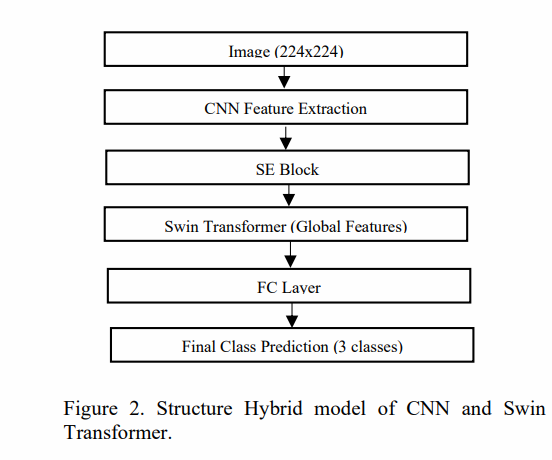


In [ ]:
# SE Attention Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        scale = self.global_avg_pool(x).view(batch, channels)
        scale = self.fc(scale).view(batch, channels, 1, 1)
        return x * scale

# **Fixed Hybrid CNN-Swin Transformer Model**
class HybridSwin(nn.Module):
    def __init__(self, num_classes=3):
        super(HybridSwin, self).__init__()

        self.conv_stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),  # No downsampling
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),  # No downsampling
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128),
            nn.Conv2d(128, 3, kernel_size=1, stride=1, padding=0, bias=False),  # Keep 3 channels for Swin input
            nn.BatchNorm2d(3),
            nn.ReLU()
        )

        self.swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=512)

        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_stem(x)  # Ensure it maintains 224×224 size
        x = self.swin(x)  # Pass to Swin Transformer
        x = self.fc(x)  # Final classification layer
        return x

common alpha [.25,.25,.25]

In [ ]:
model_2 = HybridSwin(num_classes=len(train_data.classes)).to(device)

summary(model=model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
model_2 = HybridSwin(num_classes=len(train_data.classes)).to(device)

base_optimizer = optim.AdamW(model_2.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()
model_2(image_batch.to(device))

Training Process

In [ ]:
model_2_results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
EPOCHS = 10
start_timer = timer()
for epoch in tqdm(range(EPOCHS)):
    model_2.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, memory_format=torch.channels_last), y.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred = model_2(X)
            loss = FocalLossWithLabelSmoothing()(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    model_2_results["train_loss"].append(train_loss)
    model_2_results["train_acc"].append(train_acc)
    model_2.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_dataloader):
            X, y = X.to(device, memory_format=torch.channels_last), y.to(device)
            with autocast():
                val_pred_logits = model_2(X)
                loss = FocalLossWithLabelSmoothing()(val_pred_logits, y)
            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    model_2_results["val_loss"].append(val_loss)
    model_2_results["val_acc"].append(val_acc)
    scheduler.step()
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")
torch.save(model_2.state_dict(), "model_2.pth")

Evaluation Loss curves, confusion matrix, and F1 score for experiment 2

In [ ]:
plot_loss_curves(model_2_results)

Note: in confusion matrix,


*   Class 0: Healthy

*   Class 1: Rubbish
*   Class 2: Unhealthy



In [ ]:
all_preds = []
all_labels = []
correct = 0
total = 0

model_2.eval()
with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_2_f1 = evaluate_f1(model_2, test_dataloader, device)
print(f"F1 Score on Testing Set: {model_2_f1:.4f}")

## Experiment 3
CNN + Swin Transformer

alpha = [.25,.25,.5]

Note: we used the same model in Experiment 2, but with focal weighted Loss. This helped in improving the prediction of class 2 "unhealthy class" , which has small number of examples compared to other two classes.

In [ ]:
model_3 = HybridSwin(num_classes=len(train_data.classes)).to(device)

summary(model=model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
# Optimizer and Scheduler
base_optimizer = torch.optim.AdamW(model_3.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.amp.GradScaler('cuda')

Traning Process

In [ ]:
model_3_results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
EPOCHS = 10
start_timer = timer()
for epoch in tqdm(range(EPOCHS)):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    # Training
    model_3.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, memory_format=torch.channels_last), y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            y_pred = model_3(X)
            loss = FocalLossWithClassWeights(class_alpha=[0.25, 0.25, 0.50])(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    model_3_results["train_loss"].append(train_loss)
    model_3_results["train_acc"].append(train_acc)
    # Validation
    model_3.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_dataloader):
            X, y = X.to(device, memory_format=torch.channels_last), y.to(device)
            with torch.amp.autocast('cuda'):
                val_pred_logits = model_3(X)
                loss = FocalLossWithClassWeights(class_alpha=[0.25, 0.25, 0.50])(val_pred_logits, y)
            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    model_3_results["val_loss"].append(val_loss)
    model_3_results["val_acc"].append(val_acc)
    scheduler.step()
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
end_timer = timer()
print(f"Total training time for model_3: {end_timer - start_timer:.3f} seconds")
torch.save(model_3.state_dict(), "model_3.pth")

Evaluation Loss curves, confusion matrix, and F1 score for experiment 3

In [ ]:
plot_loss_curves(model_3_results)

In [ ]:
all_preds = []
all_labels = []
correct = 0
total = 0

model_3.eval()
with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_3_f1 = evaluate_f1(model_3, test_dataloader, device)
print(f"F1 Score on Testing Set: {model_3_f1:.4f}")

## Experiment 4
Hybird model CNN+ Swin transformer
aplpha [.25 .25 .75]
Note: we used the same model in Experiment 2, but with focal weighted Loss. This helped in improving the prediction of class 2 "unhealthy class" , which has small number of examples compared to other two classes. Note: this model achieved a high F1 Score of 0.79244 in the final phase of the evaluation, which allow us to secure the top rank in this challenge. Our team in Kaggle is Lina24

In [ ]:
model_4 = HybridSwin(num_classes=len(train_data.classes)).to(device)

In [ ]:
base_optimizer = torch.optim.AdamW(model_4.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.amp.GradScaler('cuda')

Training Process

In [ ]:
model_4_results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
EPOCHS = 10
start_timer11 = timer()
for epoch in tqdm(range(EPOCHS)):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    model_4.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device, memory_format=torch.channels_last), y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            y_pred = model_4(X)
            loss = FocalLossWithClassWeights(class_alpha=[0.25,0.25,0.75])(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    model_4_results["train_loss"].append(train_loss)
    model_4_results["train_acc"].append(train_acc)

    model_4.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_dataloader):
            X, y = X.to(device, memory_format=torch.channels_last), y.to(device)
            with torch.amp.autocast('cuda'):
                val_pred_logits = model_4(X)
                loss = FocalLossWithClassWeights(class_alpha=[0.25,0.25,0.75])(val_pred_logits, y)
            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    model_4_results["val_loss"].append(val_loss)
    model_4_results["val_acc"].append(val_acc)

    scheduler.step()
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

end_timer11 = timer()
print(f"Total training time for model_4: {end_timer11 - start_timer11:.3f} seconds")
torch.save(model_4.state_dict(), "model_4.pth")

Evaluation Loss curves, confusion matrix, and F1 score for experiment 4

In [ ]:
plot_loss_curves(model_4_results)

In [ ]:
all_preds = []
all_labels = []
correct = 0
total = 0

model_4.eval()
with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_4(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_4_f1 = evaluate_f1(model_4, test_dataloader, device)
print(f"F1 Score on Testing Set: {model_4_f1:.4f}")

## Evalutaion for unlabled data from the challenge

Using Ensemble model of model 4 and model 3:

We studied the confusion matrix from the test data in the training phase "10% training data", and based on that we decided to do Ensemble of Model CNN+Swin alpha [.25 .25 .75] and Model CNN+Swin alpha [.35 .35 .75].
The ensemble model technique improved the prediction score in the final test phase and allow us to secure the second place with F1 = .79446. our Team is Lina24
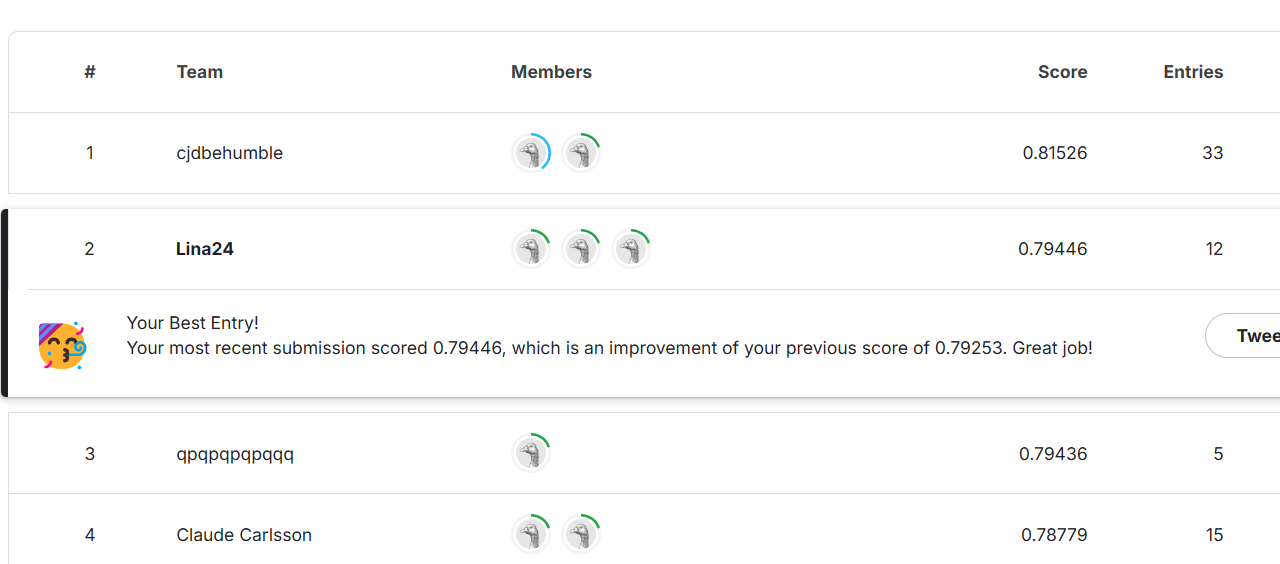

In [ ]:
model1 = HybridSwin(num_classes=3).to(device)
model2 = HybridSwin(num_classes=3).to(device)

# Load model weights with strict=False to avoid mismatch errors
model1.load_state_dict(torch.load("./model_4.pth", map_location=device), strict=False) # trained with alpha = [.25,.25,.75]
model2.load_state_dict(torch.load("./model_3.pth", map_location=device), strict=False) # trained with alpha = [.25,.25,.5]
# Set both models to evaluation mode
model1.eval()
model2.eval()

In [ ]:
evaluation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define label mapping
label_mapping = {0: "healthy", 1: "rubbish", 2: "unhealthy"}

# Path to the Evaluation folder
evaluation_folder = "./dataset/evaluation"

# List of evaluation image filenames (sorted for consistent results)
evaluation_images = sorted(os.listdir(evaluation_folder))

# Dictionary to store results
results = {"image_name": [], "label": []}

In [ ]:
with torch.inference_mode():
    for img_name in tqdm(evaluation_images, desc="Processing evaluation Images"):
        img_path = os.path.join(evaluation_folder, img_name)
        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB")
        img = evaluation_transforms(img)
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        # Perform inference with both models
        outputs_1 = model1(img)
        outputs_2 = model2(img)
        # Average the outputs for ensemble prediction
        ensemble_outputs = (outputs_1 + outputs_2) / 2
        # Get final predictions
        predicted_class = torch.argmax(ensemble_outputs, dim=1).item()
        predicted_label = label_mapping[predicted_class]  # Convert number to label
        # Store result
        results["image_name"].append(img_name)
        results["label"].append(predicted_label)

In [ ]:
# Turn the dictionary into data frame
submission_df = pd.DataFrame(results)
# Save as CSV (Kaggle format)
submission_df.to_csv("isbi2025-ps3c-test-dataset.csv", index=False)